# Denoising with B-Splines: B-Spline basis regression

## Import necessary modules

Particularly, load the optimized `bspl` implementation of the cubic B-Spline basis from `fmriprep`

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from fmriprep.utils.maths import bspl

vbspl = np.vectorize(bspl)

## Define grids

Since we are regressing a 2D image with a grid of B-Spline basis, we define the pixel size (`zooms`) of the noisy image and the spacing between knots (`kzooms`), the control points where the B-Spline basis are centered.

Then, a 2D image is generated and plotted.

In [3]:
# Define pixel spacings
zooms = [.05] * 2
kzooms = [20 * z for z in zooms]

# Create a grid
x, y = np.mgrid[-2:2.05:zooms[0], -2:2.05:zooms[1]]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

# Plot the PDF of a bivariate gaussian kernel
rv = multivariate_normal([0., 0.], [[1.0, 0.3], [0.3, 0.8]])
data = rv.pdf(pos) * 20

# Corrupt the image with noise
noise = np.random.normal(loc=0.0, scale=0.25, size=data.shape)
noisy = data + noise

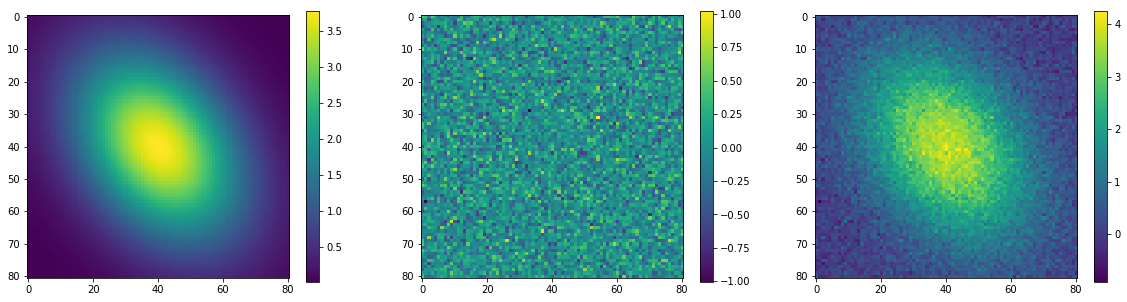

In [4]:
f, axarr = plt.subplots(1, 3, figsize=(20, 5))
im1 = axarr[0].imshow(data)
f.colorbar(im1, ax=axarr[0])
im2 = axarr[1].imshow(noise)
f.colorbar(im2, ax=axarr[1])
im3 = axarr[2].imshow(noisy)
f.colorbar(im3, ax=axarr[2])

## Define the grid of B-Spline basis

We use `kzooms` to define their separation

In [5]:
kx, ky = np.mgrid[-2:2.05:kzooms[0], -2:2.05:kzooms[1]]
kpos = np.empty(kx.shape + (2,))
kpos[:, :, 0] = kx; kpos[:, :, 1] = ky

## Regression & interpolation

The regression process is aimed at removing the noise we added in first place.

In [6]:
# Calculate the distance of every knot to every pixel center
dist = [(kpos.reshape(-1, 2) - p) / kzooms for p in pos.reshape(-1, 2)]

# Calculate the corresponding weights of the tensor B-Spline basis for every point
# This will be the design matrix
X = np.array([vbspl(d[..., 0]) * vbspl(d[..., 1]) for d in dist])

# Add a column of ones (intercept)
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

# Find the coefficients (least squares fitting)
coeff = np.linalg.lstsq(X, noisy.reshape(-1))[0]

# Interpolation of a new, smoothed image
Y = X.dot(coeff).reshape(data.shape)

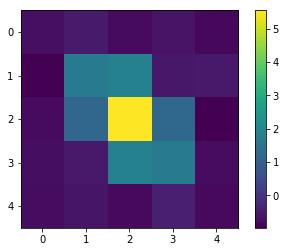

In [7]:
# Plot the coefficients - weights of each tensor B-Spline basis
plt.imshow(coeff[1:].reshape(kpos.shape[:2]))
plt.colorbar()

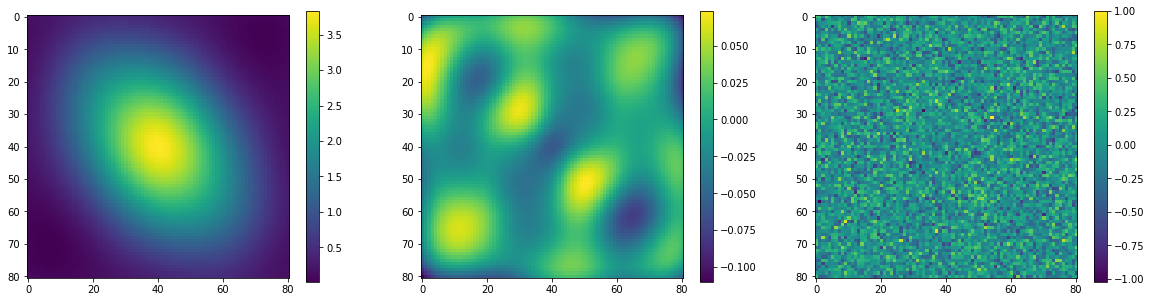

In [8]:
# Plot the interpolated (Y) image, the error w.r.t. the perfect data, and the error w.r.t. the noisy data
f, axarr = plt.subplots(1, 3, figsize=(20, 5))
im1 = axarr[0].imshow(Y)
f.colorbar(im1, ax=axarr[0])
im2 = axarr[1].imshow(data - Y)
f.colorbar(im2, ax=axarr[1])
im3 = axarr[2].imshow(noisy - Y)
f.colorbar(im3, ax=axarr[2])